# USO DE UNA RED NEURONAL MULTICAPA PARA PREDICCION DE URLs que contienen SPAM

## Importar librerias

In [26]:
# importar librerias
import numpy as np
import pandas as pd

# Cargar el conjunto de datos y preprocesarlo
data = pd.read_csv('url_spam.csv')



In [27]:
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [28]:
data['lon_url'] = data['url'].apply(lambda x : len(x))
data['contiene_sucribe'] = data['url'].apply(lambda x : 1 if "subscribe" in x else 0)
data['contiene_hash'] = data['url'].apply(lambda x : 1 if "#" in x else 0)
data['num_digitos'] = data['url'].apply(lambda x : len("".join(_ for _ in x if _.isdigit())) )
data['sin_https'] = data['url'].apply(lambda x : 1 if "https" in x else 0)
data['num_palabras'] = data['url'].apply(lambda x : len(x.split("/")))
data['contiene_?'] = data['url'].apply(lambda x : 1 if "?" in x else 0)
data['contiene_www'] = data['url'].apply(lambda x : 1 if "www" in x else 0)
data.head()

,url,is_spam,lon_url,contiene_sucribe,contiene_hash,num_digitos,sin_https,num_palabras,contiene_?,contiene_www
0,https://briefingday.us8.list-manage.com/unsubs...,True,51,1,0,1,1,4,0,0
1,https://www.hvper.com/,True,22,0,0,0,1,4,0,1
2,https://briefingday.com/m/v4n3i4f3,True,34,0,0,4,1,5,0,0
3,https://briefingday.com/n/20200618/m#commentform,False,48,0,1,8,1,6,0,0
4,https://briefingday.com/fan,True,27,0,0,0,1,4,0,0


## Encontramos las características más importantes correlacionadas con el spam o no spam

In [29]:
#separar en variables predictoras y variable a predecir
# eliminar de x la variable a predecir y la url
X = data.drop(['is_spam','url'],axis=1)
y = data['is_spam']

In [30]:
#hacer el chi2 para ver cuales son las variables mas importantes
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#aplicar el chi2 a los datos
bestfeatures = SelectKBest(score_func=chi2, k=8)
fit = bestfeatures.fit(X,y)
#obtener los scores de cada variable
dfscores = pd.DataFrame(fit.scores_)
#obtener los nombres de las variables
dfcolumns = pd.DataFrame(X.columns)
#concatenar los scores con los nombres de las variables
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#renombrar las columnas
featureScores.columns = ['Specs','Score']
#imprimir las 5 variables mas importantes
print(featureScores.nlargest(8,'Score'))


              Specs          Score
0           lon_url  465779.752395
3       num_digitos  146872.184813
5      num_palabras   12715.848585
1  contiene_sucribe    9146.541955
7      contiene_www    6752.714329
6        contiene_?    1337.976917
2     contiene_hash     543.018083
4         sin_https      21.699583


## Seleccionamos las 4 características más importantes y separamos el dataset entre variables de entrada y de salida

In [31]:
# Seleccionar las 5 variables mas importantes
X = data[['lon_url', 'num_digitos', 'num_palabras', 'contiene_sucribe']]
y = data['is_spam']

In [32]:
#tamano del conjunto de datos
print(X.shape)

(148303, 4)


In [33]:
X.head()

,lon_url,num_digitos,num_palabras,contiene_sucribe
0,51,1,4,1
1,22,0,4,0
2,34,4,5,0
3,48,8,6,0
4,27,0,4,0


In [34]:
y.head()

0     True
1     True
2     True
3    False
4     True
Name: is_spam, dtype: bool

## Normalizamos los datos para que estén entre 0 y 1, esto permite que la red neuronal mejore su aprendizaje

In [35]:
# definir la funcion para normalizar los datos
def normalizar(X):
    return (X - np.min(X)) / (np.max(X) - np.min(X))

#normalizar los datos
X = normalizar(X)

d:\ProgramFiles\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
d:\ProgramFiles\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [36]:
X.head()

,lon_url,num_digitos,num_palabras,contiene_sucribe
0,0.076305,0.007692,0.000000,1.0
1,0.018072,0.000000,0.000000,0.0
2,0.042169,0.030769,0.071429,0.0
3,0.070281,0.061538,0.142857,0.0
4,0.028112,0.000000,0.000000,0.0


In [37]:
y.head()

0     True
1     True
2     True
3    False
4     True
Name: is_spam, dtype: bool

In [38]:
#convertir y a valores numericos si es true es 1 si es false es 0
y = y.astype(int)

In [39]:
y.head()

0    1
1    1
2    1
3    0
4    1
Name: is_spam, dtype: int32

## Separamos el dataset en entrenamiento y prueba

In [40]:
#sepaprar los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split
#separar los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [41]:
#convertir los datos a arreglos de numpy
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

## Creacion de nuestra red neuronal

In [42]:
class redNeuronalMulticapa:
    
    def __init__(self, neuronas_capa_entrada, neuronas_capa_oculta, neuronas_capa_salida):
        # inicializar los pesos de manera aleatoria
        self.pesos_capa_oculta = np.random.uniform(size=(neuronas_capa_entrada, neuronas_capa_oculta))
        self.sesgo_oculto = np.random.uniform(size=(1, neuronas_capa_oculta))
        self.pesos_capa_salida = np.random.uniform(size=(neuronas_capa_oculta, neuronas_capa_salida))
        self.sesgo_salida = np.random.uniform(size=(1, neuronas_capa_salida))
        self.errores = []
        print("Pesos capa oculta: \n", self.pesos_capa_oculta)
        print("Sesgo capa oculta: \n", self.sesgo_oculto)
        print("Pesos capa salida: \n", self.pesos_capa_salida)
        print("Sesgo capa salida: \n", self.sesgo_salida)

    
    #definir la funcion de activacion
    def sigmoid(self,x):
        return 1 / (1 + np.exp(-x))

    #definir la derivada de la funcion de activacion
    def sigmoid_derivate(self,x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    


    def entrenar(self, entradas, salidas, epocas, ratio_aprendizaje):
        #realizar el entrenamiento
        for epoch in range(epocas):
            #propagacion hacia adelante
            #capa oculta
            capa_oculta = np.dot(entradas, self.pesos_capa_oculta) + self.sesgo_oculto
            capa_oculta_activada = self.sigmoid(capa_oculta)
            #capa de salida
            capa_salida = np.dot(capa_oculta_activada, self.pesos_capa_salida) + self.sesgo_salida
            capa_salida_activada = self.sigmoid(capa_salida)
            

            #propagacion hacia atras
            #capa de salida
            error_capa_salida = salidas.reshape(len(salidas), 1) - capa_salida_activada
            d_capa_salida = error_capa_salida * self.sigmoid_derivate(capa_salida_activada)
            #capa oculta
            error_capa_oculta = d_capa_salida.dot(self.pesos_capa_salida.T)
            d_capa_oculta = error_capa_oculta * self.sigmoid_derivate(capa_oculta_activada)



            #actualizar pesos y sesgos
            #capa de salida
            self.pesos_capa_salida += capa_oculta_activada.T.dot(d_capa_salida) * ratio_aprendizaje
            self.sesgo_salida += np.sum(d_capa_salida, axis=0, keepdims=True) * ratio_aprendizaje
            #capa oculta
            self.pesos_capa_oculta += entradas.T.dot(d_capa_oculta) * ratio_aprendizaje
            self.sesgo_oculto += np.sum(d_capa_oculta, axis=0, keepdims=True) * ratio_aprendizaje

            # guardar los errores en cada epoca para graficar despues
            error = np.mean(np.abs(error_capa_salida))
            self.errores.append(error)
            print("Epoca: %d, Error: %.8f" % (epoch, error))
        return { 'error': self.errores, 'pesos_capa_oculta': self.pesos_capa_oculta, 'sesgo_oculto': self.sesgo_oculto, 'pesos_capa_salida': self.pesos_capa_salida, 'sesgo_salida': self.sesgo_salida }
    
    def predecir (self, entradas):
        #capa oculta
        capa_oculta = np.dot(entradas, self.pesos_capa_oculta) + self.sesgo_oculto
        capa_oculta_activada = self.sigmoid(capa_oculta)
        
        #capa de salida
        capa_salida = np.dot(capa_oculta_activada, self.pesos_capa_salida) + self.sesgo_salida
        capa_salida_activada = self.sigmoid(capa_salida)
        return capa_salida_activada
    
    def ver_pesos_sesgos(self):
        print('pesos capa oculta: ', self.pesos_capa_oculta)
        print('sesgo oculto: ', self.sesgo_oculto)
        print('pesos capa salida: ', self.pesos_capa_salida)
        print('sesgo salida: ', self.sesgo_salida)
    
    def graficarError(self):
        import matplotlib.pyplot as plt
        plt.plot(self.errores)
        plt.xlabel('Epocas')
        plt.ylabel('Error')
        plt.show()
    
    

## Definimos los parametros de la red neuronal

In [43]:
#crearemos una red neuronal

epocas = 1000

ratio_aprendizaje = 0.0001

# definir el numero de neuronas por capa
neuronas_capa_entrada, neuronas_capa_oculta, neuronas_capa_salida = 4, 2, 1

## Vemos la salida de la red neuronal

In [44]:
# instanciar la clase
red = redNeuronalMulticapa (neuronas_capa_entrada, neuronas_capa_oculta, neuronas_capa_salida)

# entrenar la red
entrenamiento = red.entrenar(X_train, y_train, epocas, ratio_aprendizaje)

Pesos capa oculta: 
 [[0.61887721 0.56858025]
 [0.55993519 0.70568958]
 [0.18515365 0.82159785]
 [0.98440865 0.59356037]]
Sesgo capa oculta: 
 [[0.91001481 0.13733487]]
Pesos capa salida: 
 [[0.80213714]
 [0.69065688]]
Sesgo capa salida: 
 [[0.44840546]]
Epoca: 0, Error: 0.61392160
Epoca: 1, Error: 0.44538140
Epoca: 2, Error: 0.43329092
Epoca: 3, Error: 0.43327458
Epoca: 4, Error: 0.43325024
Epoca: 5, Error: 0.43322553
Epoca: 6, Error: 0.43320056
Epoca: 7, Error: 0.43317531
Epoca: 8, Error: 0.43314974
Epoca: 9, Error: 0.43312382
Epoca: 10, Error: 0.43309751
Epoca: 11, Error: 0.43307077
Epoca: 12, Error: 0.43304357
Epoca: 13, Error: 0.43301587
Epoca: 14, Error: 0.43298764
Epoca: 15, Error: 0.43295884
Epoca: 16, Error: 0.43292942
Epoca: 17, Error: 0.43289937
Epoca: 18, Error: 0.43286862
Epoca: 19, Error: 0.43283715
Epoca: 20, Error: 0.43280492
Epoca: 21, Error: 0.43277188
Epoca: 22, Error: 0.43273799
Epoca: 23, Error: 0.43270320
Epoca: 24, Error: 0.43266749
Epoca: 25, Error: 0.43263079
E

In [45]:
red.ver_pesos_sesgos()

pesos capa oculta:  [[-0.43653138  6.107297  ]
 [ 0.31880678  3.06084168]
 [-0.04088365  2.60435306]
 [ 2.87426171 -9.00984969]]
sesgo oculto:  [[ 0.77793202 -1.43140152]]
pesos capa salida:  [[ 2.37026067]
 [-8.00378739]]
sesgo salida:  [[0.7008066]]


## Graficamos los errores

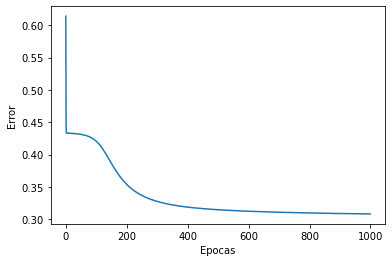

In [46]:
#graficar el error
red.graficarError()

## Verificamos el desempeño de la red neuronal

In [47]:
#ver la precision del modelo
predicciones = red.predecir(X_test)

#redondear las predicciones
predicciones = np.round(predicciones)


In [48]:
#ver la precision del modelo
from sklearn.metrics import accuracy_score
print("Precision del modelo: ", accuracy_score(y_test, predicciones))

Precision del modelo:  0.7702231912072105


In [49]:
#hacer una reporte de clasificacion
from sklearn.metrics import classification_report
print(classification_report(y_test, predicciones))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83     30242
           1       0.66      0.59      0.62     14249

    accuracy                           0.77     44491
   macro avg       0.74      0.72      0.73     44491
weighted avg       0.77      0.77      0.77     44491



In [50]:
resultado = "Vemos que el modelo puede clasificar mejor las url que no son spam que los que son spam y en general se tiene una precisión del {}%".format(accuracy_score(y_test,predicciones)*100) + "\ncon lo cual podemos decir que el modelo es bueno para clasificar los correos"
print(resultado)


Vemos que el modelo puede clasificar mejor las url que no son spam que los que son spam y en general se tiene una precisión del 77.02231912072105%
con lo cual podemos decir que el modelo es bueno para clasificar los correos
